In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 模型主体

In [31]:

class RegressionDataset(Dataset):
    """自定义数据集类"""

    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y).reshape(-1,1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class RegressionNet(nn.Module):
    """回归神经网络模型"""

    def __init__(self, input_dim, hidden_dim):
        super(RegressionNet, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.layer2(x)
        return x


def read_data(file_path):
    """读取数据文件"""
    data_temp = []
    with open(file_path) as fdata:
        for line in fdata:
            data_temp.append([float(i) for i in line.split()])
    return np.array(data_temp)


def prepare_data(X, y, batch_size=32, test_size=0.2):
    """准备数据集"""
    # 数据标准化
    X_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    X_normalized = X_scaler.fit_transform(X)
    y_normalized = y_scaler.fit_transform(y.reshape(-1, 1))

    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(
        X_normalized, y_normalized,
        test_size=test_size,
        random_state=42
    )

    # 创建数据加载器
    train_dataset = RegressionDataset(X_train, y_train)
    test_dataset = RegressionDataset(X_test, y_test)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False
    )

    return train_loader, test_loader, (X_scaler, y_scaler)


def train_model(model, train_loader, criterion, optimizer, device, epochs=100):
    """训练模型"""
    model.train()
    train_losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # 前向传播
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # 计算平均损失
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}')

    return train_losses


def evaluate_model(model, test_loader, criterion, device):
    """评估模型"""
    model.eval()
    total_loss = 0
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()

            predictions.extend(outputs.cpu().numpy())
            actuals.extend(batch_y.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    return avg_loss, np.array(predictions), np.array(actuals)
def plot_results(train_losses, predictions, actuals, y_scaler=None):
    """绘制结果"""
    # 绘制损失曲线
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # 绘制预测vs实际值
    plt.subplot(1, 2, 2)
    if y_scaler is not None:
        predictions = y_scaler.inverse_transform(predictions)
        actuals = y_scaler.inverse_transform(actuals)

    plt.scatter(actuals, predictions, alpha=0.5)
    plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--')
    plt.title('Predictions vs Actuals')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend('best')
    plt.tight_layout()
    plt.show()



# 主程序

In [46]:
import pandas as pd
data = pd.read_csv('USA_modified_data.csv')
print(data.head())




   NOC  Year  Total_num  sport_participant_count  event_participant_count  \
0  USA  1896         27                        3                       16   
1  USA  1900        135                       10                       41   
2  USA  1904       1109                       18                       95   
3  USA  1908        219                       10                       52   
4  USA  1912        364                       11                       68   

   comprehensive_score  host_country  advantage_event_count  Last_Total  \
0             0.000000             0                     12           0   
1             0.499171             0                     23          20   
2             0.425546             1                     86          48   
3             0.418750             0                     90         231   
4             0.385865             0                     97          47   

   Unnamed: 9  Unnamed: 10  Gold  Total  
0         NaN          NaN    11     20  
1 

In [51]:
X = data.iloc[:, 3:8].values  # 选择第3列和第4列作为特征
y = data.iloc[:, 12].values    # 选择第5列作为目标值

print(X.shape,y.shape)
print(X,y)

(33, 5) (33,)
[[  3.          16.           0.           0.          12.        ]
 [ 10.          41.           0.49917115   0.          23.        ]
 [ 18.          95.           0.42554633   1.          86.        ]
 [ 10.          52.           0.41874953   0.          90.        ]
 [ 11.          68.           0.3858655    0.          97.        ]
 [  0.           0.           0.38103031   0.          97.        ]
 [ 18.         113.           0.37178948   0.         114.        ]
 [ 18.         108.           0.39049941   0.         125.        ]
 [ 15.          96.           0.38605473   0.          71.        ]
 [ 17.         122.           0.35911425   1.          74.        ]
 [ 21.         127.           0.35987629   0.          65.        ]
 [  0.           0.           0.34924827   0.          65.        ]
 [  0.           0.           0.32728489   0.          51.        ]
 [ 19.         126.           0.30208794   0.          41.        ]
 [ 18.         133.           0.39

Epoch [10/100], Loss: 0.0207
Epoch [20/100], Loss: 0.0173
Epoch [30/100], Loss: 0.0153
Epoch [40/100], Loss: 0.0137
Epoch [50/100], Loss: 0.0129
Epoch [60/100], Loss: 0.0119
Epoch [70/100], Loss: 0.0111
Epoch [80/100], Loss: 0.0100
Epoch [90/100], Loss: 0.0091
Epoch [100/100], Loss: 0.0083
Test Loss: 0.0155


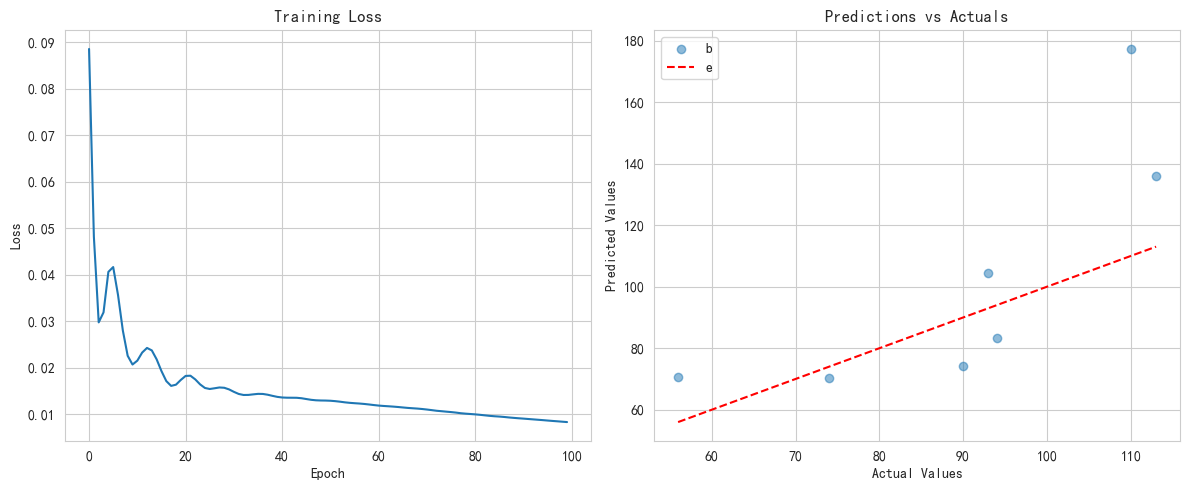

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loader, test_loader, scalers = prepare_data(X, y, batch_size=32)
X_scaler, y_scaler = scalers

# 创建模型
model = RegressionNet(input_dim=5, hidden_dim=32).to(device)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 训练模型
train_losses = train_model(
    model,
    train_loader,
    criterion,
    optimizer,
    device,
    epochs=100
)

# 评估模型
test_loss, predictions, actuals = evaluate_model(
    model,
    test_loader,
    criterion,
    device
)
print(f'Test Loss: {test_loss:.4f}')

# 绘制结果
plot_results(train_losses, predictions, actuals, y_scaler)

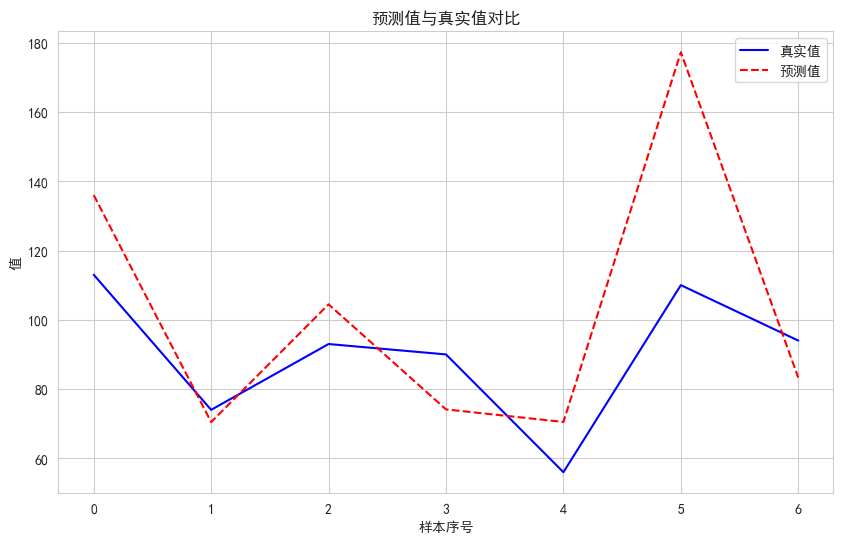

In [53]:
def plot_prediction_comparison(predictions, actuals, y_scaler=None):
    """绘制预测值和真实值的对比图"""
    if y_scaler is not None:
        predictions = y_scaler.inverse_transform(predictions)
        actuals = y_scaler.inverse_transform(actuals)

    plt.figure(figsize=(10, 6))
    plt.plot(actuals, label='真实值', color='blue')
    plt.plot(predictions, label='预测值', color='red', linestyle='--')
    plt.title('预测值与真实值对比')
    plt.xlabel('样本序号')
    plt.ylabel('值')
    plt.legend()
    plt.grid(True)
    plt.show()
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

# 在main()函数中调用:
test_loss, predictions, actuals = evaluate_model(model, test_loader, criterion, device)
plot_prediction_comparison(predictions, actuals, y_scaler)